# Adventures in Zero-Shot Text Classification

Transfer learning has had an enormous impact in Natural Language Processing. Thanks to models like BERT, it is now possible to train more accurate NLP models than before, and typically do so with less labeled data. Now that finetuning language models has become the standard procedure in NLP, it’s only natural to get curious and ask: do we need any task-specific labeled training items at all?

In this notebook, we investigate two available models for zero-shot text classification and evaluate how they perform. The code for this article is available in [our repository of NLP notebooks](https://nlptown.github.io/nlp-notebooks/).

## Zero-shot text classification

Zero-shot and few-shot NLP models take transfer learning to the extreme: their goal is to make predictions for an NLP task without having seen one single labeled item (for zero-shot learning), or very few such items (for few-shot learning) specific to that task. The most well-known example is doubtlessly [OpenAI’s GPT-3](https://arxiv.org/abs/2005.14165), which has proved to be a very successful few-shot learner for a wide range of applications. While running GPT-3 lies beyond the means of most developers, luckily several smaller alternatives are available.

In 2020, [Flair](https://github.com/flairNLP/flair) and [Transformers](https://huggingface.co/transformers/), two of the most popular NLP libraries, both added zero-shot classification to their offering. Flair, on the one hand, makes use of a so-called TARS classifier, short for [Text-Aware Representation of Sentences](https://kishaloyhalder.github.io/pdfs/tars_coling2020.pdf), which can be run with just a few lines of code:

```
classifier = TARSClassifier.load('tars-base')
sentence = Sentence('Your example text')
classifier.predict_zero_shot(sentence, [label1, label2, …])
```

Transformers, on the other hand, makes it possible to use a range of models from the [Hugging Face model hub](https://huggingface.co/models) in their `zero-shot-classification` pipeline:

```
classifier = pipeline('zero-shot-classification', model="your-nli-model", device=0)
classifier('Your example text', [label1, label2, …])
```

Despite the obvious similarities, the two implemented classifiers approach zero-shot text classification quite differently.

The zero-shot pipeline in the Transformers library treats text classification as natural language inference (NLI). This approach was pioneered by [Yin et al. in 2019](https://arxiv.org/abs/1909.00161). In NLI, a model takes two sentences as input &mdash; a premise and a hypothesis &mdash; and decides whether the hypothesis follows from the premise (`entailment`), contradicts it (`contradiction`), or neither (`neutral`). For example, the premise _David killed Goliath_ entails the hypothesis _Goliath is dead_, is contradicted by _Goliath is alive_ and doesn’t allow us to draw any conclusions about _Goliath is a giant_. This NLI template can be reused for text classification by taking the text we’d like to label as the premise, and rephrasing every candidate class as a hypothesis. For a task such as polarity classification, the premise could be an opinion like _I loved this movie_, with the hypotheses _This sentence is positive_, _This sentence is negative_ or _This sentence is neutral_. The classifier will then determine the relationship between the premise and every hypothesis. In single-label classification, all resulting `entailment` scores are softmaxed to identify the single most probable class; in multi-label classification, the scores for `entailment` and `contradiction` are softmaxed for every label independently, so that several relevant labels can be identified.

The TARS classifier in the Flair library takes a different course. Similar to the previous approach, it abstracts away from the specificities of individual classification tasks by feeding both the label and the text as input to a BERT classifier, separated by the `[SEP]` token. The main difference lies in the fact that this BERT model is not finetuned for NLI, but for a generic version of text classification. This is done by training the model to label every input pair as either true or false. To make sure it can handle a variety of classification tasks, Flair’s TARS classifier is finetuned on nine different datasets, with applications ranging from polarity to topic classification. For single-label classification, only the class with the highest score for `True` is selected as the final prediction; for multi-label classification, all classes with the prediction `True` are returned.

Although both approaches to zero-shot classification sound very attractive, they share one disadvantage: in contrast to traditional text classification, each input text requires several forward passes through the model &mdash; one for each candidate label. The models are therefore less computationally efficient than more traditional text classifiers. Still, if they can bypass the need for expensive data labeling, for many applications this may be a small price to pay.

## Data

The more pressing question is therefore how well zero-shot text classification works exactly. To find out, we evaluated the classifiers above on five different tasks, from topic classification to sentiment analysis. We used four datasets that are all available from the [Hugging Face datasets hub](https://huggingface.co/datasets),
making sure that none of these datasets was used to finetune Flair’s TARS classifier. From each we selected 1,000 random test items:

- [yahoo_answers_topics](https://huggingface.co/datasets/yahoo_answers_topics): questions and answers from Yahoo Answers, classified into 10 topics, such as `Society & Culture` and `Science & Mathematics`. As the input to the model we use the best answer only (without the question).
- [banking 77](https://huggingface.co/datasets/banking77): a set of online user queries from the banking domain, each labeled with one of 77 intents. This is a challenging dataset, as the intents (such as `card_about_to_expire` and `card_not_working`) are very fine-grained.
- [tweet_eval](https://huggingface.co/datasets/tweet_eval): English tweets labeled for a variety of tasks. We tested if the models can predict the emotion &mdash; `anger`, `joy`, `optimism` or `sadness` &mdash; and the sentiment polarity of the tweets &mdash; `positive`, `negative` or `neutral`.
- [financial_phrasebank](https://huggingface.co/datasets/financial_phrasebank): financial news sentences (such as _Sales have risen in other export markets_) with a polarity label &mdash; `positive`, `negative` or `neutral`. We only selected sentences for which all annotators agreed on the label.

In [1]:
from datasets import load_dataset

yahoo = load_dataset('yahoo_answers_topics')
banking = load_dataset('banking77')
amazon = load_dataset('amazon_reviews_multi')
financial = load_dataset('financial_phrasebank', 'sentences_allagree')
tweets = load_dataset('tweet_eval', 'sentiment')
tweets_emotion = load_dataset('tweet_eval', 'emotion')

Reusing dataset yahoo_answers_topics (/home/yves/.cache/huggingface/datasets/yahoo_answers_topics/yahoo_answers_topics/1.0.0/a1bc78ef81f1057593777a45c199fada1fd6decb8a3d9f5aea63b47dc884b0dd)
Couldn't find file locally at banking77/banking77.py, or remotely at https://raw.githubusercontent.com/huggingface/datasets/1.4.1/datasets/banking77/banking77.py.
The file was picked from the master branch on github instead at https://raw.githubusercontent.com/huggingface/datasets/master/datasets/banking77/banking77.py.
Using custom data configuration default
Reusing dataset banking77 (/home/yves/.cache/huggingface/datasets/banking77/default/1.1.0/17ffc2ed47c2ed928bee64127ff1dbc97204cb974c2f980becae7c864007aed9)
No config specified, defaulting to: amazon_reviews_multi/all_languages
Reusing dataset amazon_reviews_multi (/home/yves/.cache/huggingface/datasets/amazon_reviews_multi/all_languages/1.0.0/f3357bd271e187385a38574fe31b8fb10055303f67fa9fce55e84d08c4870efd)
Reusing dataset financial_phrasebank

In [2]:
import re

def clean(label):
    label = re.sub("([a-z])([A-Z])", "\\1 \\2", label)
    label = label.replace("_", " ")
    return label

In [3]:
import random

random.seed(1)

def sample_test_data(texts,  labels, size):
    
    data = list(zip(texts, labels))
    data = [item for item in data if len(item[0].strip()) > 0]
    
    random.shuffle(data)

    texts, labels = zip(*data)
    
    return texts[:size], labels[:size], texts[size:], labels[size:]


In [4]:
yahoo_test_texts, yahoo_test_labels, _, _ = sample_test_data(yahoo['test']['best_answer'], yahoo['test']['topic'], 1000)
banking_test_texts, banking_test_labels, _, _ = sample_test_data(banking['test']['text'], banking['test']['label'], 1000)
financial_test_texts, financial_test_labels, financial_train_texts, financial_train_labels = sample_test_data(financial['train']['sentence'], financial['train']['label'], 1000)
tweets_test_texts, tweets_test_labels, _, _ = sample_test_data(tweets['test']['text'], tweets['test']['label'], 1000)
tweets_emotion_test_texts, tweets_emotion_test_labels, _, _ = sample_test_data(tweets_emotion['test']['text'], tweets_emotion['test']['label'], 1000)

In [5]:
data = [
    {
        "name": "yahoo_answers_topics", 
        "test_texts": yahoo_test_texts, 
        "test_labels": yahoo_test_labels, 
        "train_texts": yahoo['train']['best_answer'], 
        "train_labels": yahoo['train']['topic'], 
        "class_names": [clean(label) for label in yahoo['test'].features['topic'].names]
    },
    {
        "name": "banking77", 
        "test_texts": banking_test_texts,
        "test_labels": banking_test_labels, 
        "train_texts": banking['train']['text'], 
        "train_labels": banking['train']['label'], 
        "class_names": [clean(label) for label in banking['test'].features['label'].names]
    },    
    {
        "name": "tweet_eval: emotion", 
        "test_texts": tweets_emotion_test_texts, 
        "test_labels": tweets_emotion_test_labels, 
        "train_texts": tweets_emotion['train']['text'], 
        "train_labels": tweets_emotion['train']['label'], 
        "class_names": [clean(label) for label in tweets_emotion['test'].features['label'].names]
    },
    {
        "name": "tweet_eval: sentiment", 
        "test_texts": tweets_test_texts, 
        "test_labels": tweets_test_labels,
        "train_texts": tweets['train']['text'], 
        "train_labels": tweets['train']['label'],
        "class_names": [clean(label) for label in tweets['test'].features['label'].names]
    },
    {
        "name": "financial_phrasebank", 
        "test_texts": financial_test_texts, 
        "test_labels": financial_test_labels, 
        "train_texts": financial_train_texts, 
        "train_labels": financial_train_labels, 
        "class_names":  [clean(label) for label in financial['train'].features['label'].names]
    }    
]

## The models

We used three different zero-shot text classifiers in our tests: Flair’s `TARSClassifier`, and two Transformers models finetuned for NLI: `bart-large-mnli` and `roberta-large-mnli`. The graph below shows their accuracies on the five tasks. The results are as varied as the datasets, but one pattern is immediately clear: the best model always takes the NLI approach. For the Yahoo Answers topics, Bart gives the best accuracy (39.2%), followed by TARS and Roberta, which both obtain 27.5%. Although the banking task appears much more challenging at first sight, the NLI models perform even better here: they both classify over 41% of the test items correctly, leaving the TARS classifier far behind. On four-way tweet emotion classification, both Bart (73.6%) and Roberta (71.9%) perform surprisingly well and easily beat TARS (32.3%).

The two polarity tasks deserve some additional explanation. Because our first evaluation run showed very low scores for TARS (accuracies below the random baseline of 33%), we took a closer look at the results and found that in most cases, TARS failed to predict a single label for the news sentences and tweets. To fix this, we performed a second run, where we made TARS return `neutral` for every sentence without a label. It is those scores you see below.
For both polarity tasks, Roberta gives the best results, with 54.0% accuracy for the tweets and 58.8% for the
financial news sentences. TARS and Bart obtain a similar result on the tweets, with 48.2% and 49.0% accuracy, respectively. On the financial news sentences, TARS is better, with 51.7% against 38.8%.

In [6]:
from flair.models.text_classification_model import TARSClassifier
from flair.data import Sentence
from tqdm.notebook import tqdm

def evaluate_flair(dataset, default_name='neutral'):

    classifier = TARSClassifier.load('tars-base')
        
    total, correct = 0, 0
    for item, gold_label_idx in tqdm(zip(dataset["test_texts"], dataset["test_labels"]), total = len(dataset["test_texts"])):
        sentence = Sentence(item)
        classifier.predict_zero_shot(sentence, dataset["class_names"])
        sorted_labels = sorted(sentence.to_dict()['labels'], key=lambda k: k['confidence'], reverse=True)
        gold_label = dataset["class_names"][gold_label_idx]
        if len(sorted_labels) > 0:
            predicted_label = sorted_labels[0]['value']
        else:
            predicted_label = default_name
        if predicted_label == gold_label:
            correct += 1
        total += 1
        
    return correct/total

In [7]:
import numpy as np
from transformers import pipeline

def evaluate_huggingface(dataset, template=None, model='base'):

    if model == 'base':
        classifier = pipeline("zero-shot-classification", device=0)
    else:
        classifier = pipeline("zero-shot-classification", model="roberta-large-mnli", device=0)
    
    correct = 0
    predictions, gold_labels = [], []
    for text, gold_label_idx in tqdm(zip(dataset["test_texts"], dataset["test_labels"]), total=len(dataset["test_texts"])):

        if template is not None:
            result = classifier(text, dataset["class_names"], multi_label=False, template=template)
        else:
            result = classifier(text, dataset["class_names"], multi_label=False)
        predicted_label = result['labels'][0]
        
        gold_label = dataset["class_names"][gold_label_idx]
        
        predictions.append(predicted_label)
        gold_labels.append(gold_label)
        
        if predicted_label == gold_label:
            correct += 1
            
    accuracy = correct/len(predictions)
    return accuracy


## Evaluation

In [8]:
results = {}

for dataset in data:
    print(dataset['name'])
    results[dataset['name']] = {}
    
    flair_acc = evaluate_flair(dataset)
    results[dataset['name']]['Flair TARS'] = flair_acc
    print("Flair:", flair_acc)
    
    huggingface_acc = evaluate_huggingface(dataset)
    results[dataset['name']]['Transformers Bart'] = huggingface_acc
    print("Huggingface Bart", huggingface_acc)

    huggingface_acc_roberta = evaluate_huggingface(dataset, model='roberta')
    results[dataset['name']]['Transformers Roberta'] = huggingface_acc_roberta
    print("Huggingface Roberta", huggingface_acc_roberta)
    


yahoo_answers_topics
2021-05-25 10:35:55,743 loading file /home/yves/.flair/models/tars-base-v8.pt
init TARS



Flair: 0.275



Huggingface Bart 0.392


Some weights of the model checkpoint at roberta-large-mnli were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).



Huggingface Roberta 0.275
banking77
2021-05-25 10:41:14,247 loading file /home/yves/.flair/models/tars-base-v8.pt
init TARS



Flair: 0.109



Huggingface Bart 0.41


Some weights of the model checkpoint at roberta-large-mnli were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).



Huggingface Roberta 0.413
tweet_eval: emotion
2021-05-25 10:52:26,358 loading file /home/yves/.flair/models/tars-base-v8.pt
init TARS



Flair: 0.323



Huggingface Bart 0.736


Some weights of the model checkpoint at roberta-large-mnli were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).



Huggingface Roberta 0.719
tweet_eval: sentiment
2021-05-25 10:53:59,809 loading file /home/yves/.flair/models/tars-base-v8.pt
init TARS



Flair: 0.482



Huggingface Bart 0.49


Some weights of the model checkpoint at roberta-large-mnli were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).



Huggingface Roberta 0.54
financial_phrasebank
2021-05-25 10:55:23,729 loading file /home/yves/.flair/models/tars-base-v8.pt
init TARS



Flair: 0.517



Huggingface Bart 0.388


Some weights of the model checkpoint at roberta-large-mnli were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).



Huggingface Roberta 0.588


<AxesSubplot:>

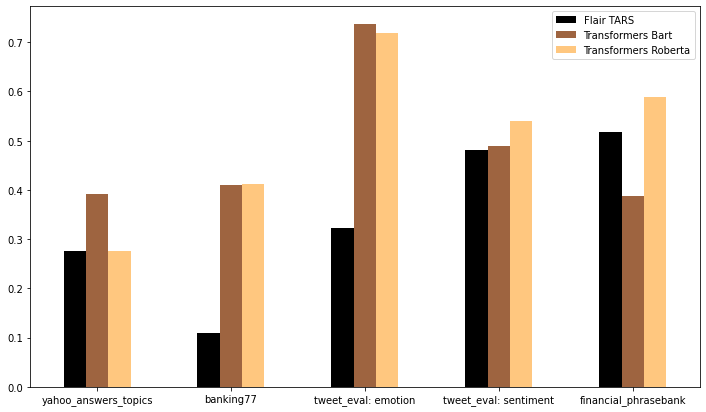

In [9]:
import pandas as pd

df = pd.DataFrame.from_dict(results)
df = df.transpose()
df.plot(kind='bar', figsize=(12,7), colormap='copper', rot=0)

## The impact of class names

In traditional supervised learning, the actual names of the labels do not have any impact on the performance of the model. You’re free to call your classes whatever you want &mdash; `positive`, `politics` or `aardvark`, it makes no difference at all. In zero-shot text classification, these names suddenly become important. Both the NLI and TARS classifiers add the label itself to the input of the model, so that the class names have the power to change the predictions. In general, the more semantic information about the class they contain, and the more similar they are to the type of data that the model was finetuned on, the better we can expect the classifier to perform.

Let’s take polarity classification as an example. While `positive`, `neutral` and `negative` are the traditional class names for this task, they may not be optimal for a zero-shot approach. To test this out, we experimented
with two alternative sets of names for the financial news data: `good news`, `neutral news` and `bad news` on the one hand, and `happy news`, `neutral news` and `unhappy news` on the other. As you can see in the figure below, this has a very positive effect on the accuracy of the classifiers. Both TARS (62.0%) and Bart (61.9%) now perform better than the original Roberta, although Bart only does so with the happy/unhappy class names. Roberta itself jumps another 13%, to an accuracy of over 73% with both alternative sets of names. Zero-shot classifiers may reduce the need for labeling, but they do introduce the necessary task of searching for good class names.

In [10]:
print(data[3]["class_names"])

['negative', 'neutral', 'positive']


In [23]:
alternative_results = {}
alternative_results['positive/negative'] = results['financial_phrasebank']

alternative_financial_news = {
    "name": "good/bad", 
    "test_texts": financial_test_texts, 
    "test_labels": financial_test_labels, 
    "class_names":  ["bad news", "neutral news", "good news"]
    }

alternative_results[alternative_financial_news['name']] = {}
flair_acc = evaluate_flair(alternative_financial_news, default_name='neutral news')
alternative_results[alternative_financial_news['name']]['Flair TARS'] = flair_acc
print("Flair:", flair_acc)

huggingface_acc = evaluate_huggingface(alternative_financial_news)
alternative_results[alternative_financial_news['name']]['Transformers Bart'] = huggingface_acc
print("Huggingface Bart", huggingface_acc)

huggingface_acc_roberta = evaluate_huggingface(alternative_financial_news, model='roberta')
alternative_results[alternative_financial_news['name']]['Transformers Roberta'] = huggingface_acc_roberta
print("Huggingface Roberta", huggingface_acc_roberta)


2021-05-25 11:49:41,900 loading file /home/yves/.flair/models/tars-base-v8.pt
init TARS



Flair: 0.619



Huggingface Bart 0.458


Some weights of the model checkpoint at roberta-large-mnli were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).



Huggingface Roberta 0.738


In [25]:
alternative_financial_news = {
    "name": "happy/unhappy", 
    "test_texts": financial_test_texts, 
    "test_labels": financial_test_labels, 
    "class_names":  ["unhappy news", "neutral news", "happy news"]
    }

alternative_results[alternative_financial_news['name']] = {}
flair_acc = evaluate_flair(alternative_financial_news, default_name='neutral news')
alternative_results[alternative_financial_news['name']]['Flair TARS'] = flair_acc
print("Flair:", flair_acc)

huggingface_acc = evaluate_huggingface(alternative_financial_news)
alternative_results[alternative_financial_news['name']]['Transformers Bart'] = huggingface_acc
print("Huggingface Bart", huggingface_acc)

huggingface_acc_roberta = evaluate_huggingface(alternative_financial_news, model='roberta')
alternative_results[alternative_financial_news['name']]['Transformers Roberta'] = huggingface_acc_roberta
print("Huggingface Roberta", huggingface_acc_roberta)

2021-05-25 11:51:31,776 loading file /home/yves/.flair/models/tars-base-v8.pt
init TARS



Flair: 0.62



Huggingface Bart 0.619


Some weights of the model checkpoint at roberta-large-mnli were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).



Huggingface Roberta 0.735


<AxesSubplot:>

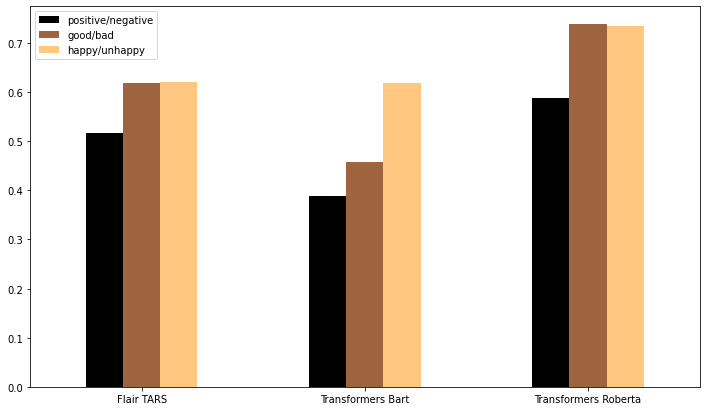

In [26]:
df = pd.DataFrame.from_dict(alternative_results)
df.plot(kind='bar', figsize=(12,7), colormap='copper', rot=0)

In [14]:
df

,positive/negative,good/bad,happy/unhappy
Flair TARS,0.517,0.619,0.178
Transformers Bart,0.388,0.458,0.619
Transformers Roberta,0.588,0.588,0.588


## Few-shot learning

As we saw with polarity classification, the TARS classifier tends to suffer from low recall. In tasks with a default class, such as `neutral`, this label can serve as a fallback option, but in other cases we need a different solution.
Luckily, Flairs has made it easy to finetune TARS on a handful of training examples. Let’s see what happens if we give the model one example of what we mean by each class, and finetune it on this small training set. Because the performance of the final model will depend on what training instances we pick, we repeat this process ten times and always select random examples from the training corpus.

The figure below shows that the TARS classifier benefits greatly from this few-shot learning procedure. The impact is clearest for the three tasks without a default class: TARS’s accuracy jumps significantly, and in two out of three cases it becomes competitive with the best NLI model. Interestingly, this even happens for the emotion dataset, where we’ve used just four examples as our training set. For the polarity tasks, the benefit is less clear, as we already fixed the recall problem by introducing a default class, and only worked with three labeled examples for few-shot learning.

In [15]:
from flair.data import Corpus
from flair.datasets import SentenceDataset

def sample_training_corpus(dataset, seed):

    random.seed(seed)
    
    seen_labels = set()
    sentences = []

    train_set = list(zip(dataset['train_texts'], dataset['train_labels']))
    random.shuffle(train_set)
    
    for text, label in train_set:
        topic = dataset['class_names'][label]
        if topic not in seen_labels:
            sentences.append(Sentence(text).add_label("_or_".join(dataset['class_names']), topic))
            seen_labels.add(topic)
        if len(seen_labels) == len(dataset['class_names']):
            break

    train = SentenceDataset(sentences)
    corpus = Corpus(train=train)
    return corpus

In [16]:
from flair.trainers import ModelTrainer

def train(corpus, dataset):

    tars = TARSClassifier.load('tars-base')
    tars.add_and_switch_to_new_task(dataset['name'], label_dictionary=corpus.make_label_dictionary())

    trainer = ModelTrainer(tars, corpus)

    trainer.train(base_path='/tmp/' + dataset['name'], # path to store the model artifacts
              learning_rate=0.02, # use very small learning rate
              mini_batch_size=1, # small mini-batch size since corpus is tiny
              max_epochs=10, # terminate after 10 epochs
              train_with_dev=False,
              )

In [30]:
def evaluate(dataset, default_name='neutral'):
    tars = TARSClassifier.load(f'/tmp/{dataset["name"]}/final-model.pt')

    total, correct = 0, 0
    for item, gold_label_idx in tqdm(zip(dataset["test_texts"], dataset["test_labels"]), total = len(dataset["test_texts"])):
        sentence = Sentence(item)
        tars.predict(sentence)
        sorted_labels = sorted(sentence.to_dict()['labels'], key=lambda k: k['confidence'], reverse=True)
        
        gold_label = dataset["class_names"][gold_label_idx]
        if len(sorted_labels) > 0:
            predicted_label = sorted_labels[0]['value']
        else:
            predicted_label = default_name                

        if predicted_label == gold_label:
            correct += 1

        total += 1

    return correct/total

In [31]:
#results_fewshot = {}

for dataset in data[3:]:
    results_fewshot[dataset['name']] = []
    for seed in range(10):

        corpus = sample_training_corpus(dataset, seed)
        train(corpus, dataset)
        acc = evaluate(dataset)
        results_fewshot[dataset['name']].append(acc)

        print("Accuracy:", acc)

2021-05-25 12:10:45,968 loading file /home/yves/.flair/models/tars-base-v8.pt
init TARS
2021-05-25 12:10:49,908 Computing label dictionary. Progress:


100%|██████████| 3/3 [00:00<00:00, 9656.88it/s]

2021-05-25 12:10:49,911 [b'negative', b'neutral', b'positive']
2021-05-25 12:10:49,912 ----------------------------------------------------------------------------------------------------
2021-05-25 12:10:49,914 Model: "TARSClassifier(
  (document_embeddings): None
  (decoder): None
  (loss_function): None
  (tars_model): TextClassifier(
    (document_embeddings): TransformerDocumentEmbeddings(
      (model): BertModel(
        (embeddings): BertEmbeddings(
          (word_embeddings): Embedding(30522, 768, padding_idx=0)
          (position_embeddings): Embedding(512, 768)
          (token_type_embeddings): Embedding(2, 768)
          (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (dropout): Dropout(p=0.1, inplace=False)
        )
        (encoder): BertEncoder(
          (layer): ModuleList(
            (0): BertLayer(
              (attention): BertAttention(
                (self): BertSelfAttention(
                  (query): Linear(in_features=768, o

2021-05-25 12:10:49,915 ----------------------------------------------------------------------------------------------------
2021-05-25 12:10:49,915 Corpus: "Corpus: 3 train + 0 dev + 0 test sentences"
2021-05-25 12:10:49,915 ----------------------------------------------------------------------------------------------------
2021-05-25 12:10:49,915 Parameters:
2021-05-25 12:10:49,915  - learning_rate: "0.02"
2021-05-25 12:10:49,916  - mini_batch_size: "1"
2021-05-25 12:10:49,916  - patience: "3"
2021-05-25 12:10:49,916  - anneal_factor: "0.5"
2021-05-25 12:10:49,916  - max_epochs: "10"
2021-05-25 12:10:49,917  - shuffle: "True"
2021-05-25 12:10:49,917  - train_with_dev: "False"
2021-05-25 12:10:49,917  - batch_growth_annealing: "False"
2021-05-25 12:10:49,917 ----------------------------------------------------------------------------------------------------
2021-05-25 12:10:49,918 Model training base path: "/tmp/tweet_eval: sentiment"
2021-05-25 12:10:49,918 --------------------------

saving best model
2021-05-25 12:10:50,742 ----------------------------------------------------------------------------------------------------
2021-05-25 12:10:50,799 epoch 2 - iter 1/3 - loss 0.43752971 - samples/sec: 22.85 - lr: 0.020000
2021-05-25 12:10:50,845 epoch 2 - iter 2/3 - loss 0.24862534 - samples/sec: 22.04 - lr: 0.020000
2021-05-25 12:10:50,888 epoch 2 - iter 3/3 - loss 0.33462723 - samples/sec: 23.54 - lr: 0.020000
2021-05-25 12:10:50,889 ----------------------------------------------------------------------------------------------------
2021-05-25 12:10:50,889 EPOCH 2 done: loss 0.3346 - lr 0.0200000
2021-05-25 12:10:50,890 BAD EPOCHS (no improvement): 1
2021-05-25 12:10:50,890 ----------------------------------------------------------------------------------------------------
2021-05-25 12:10:50,946 epoch 3 - iter 1/3 - loss 0.16561399 - samples/sec: 22.18 - lr: 0.020000
2021-05-25 12:10:50,986 epoch 3 - iter 2/3 - loss 0.09413094 - samples/sec: 24.92 - lr: 0.020000
20


Accuracy: 0.522
2021-05-25 12:11:06,271 loading file /home/yves/.flair/models/tars-base-v8.pt
init TARS
2021-05-25 12:11:10,001 Computing label dictionary. Progress:


100%|██████████| 3/3 [00:00<00:00, 11607.85it/s]

2021-05-25 12:11:10,003 [b'positive', b'negative', b'neutral']
2021-05-25 12:11:10,004 ----------------------------------------------------------------------------------------------------
2021-05-25 12:11:10,005 Model: "TARSClassifier(
  (document_embeddings): None
  (decoder): None
  (loss_function): None
  (tars_model): TextClassifier(
    (document_embeddings): TransformerDocumentEmbeddings(
      (model): BertModel(
        (embeddings): BertEmbeddings(
          (word_embeddings): Embedding(30522, 768, padding_idx=0)
          (position_embeddings): Embedding(512, 768)
          (token_type_embeddings): Embedding(2, 768)
          (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (dropout): Dropout(p=0.1, inplace=False)
        )
        (encoder): BertEncoder(
          (layer): ModuleList(
            (0): BertLayer(
              (attention): BertAttention(
                (self): BertSelfAttention(
                  (query): Linear(in_features=768, o

2021-05-25 12:11:10,006 ----------------------------------------------------------------------------------------------------
2021-05-25 12:11:10,006 Corpus: "Corpus: 3 train + 0 dev + 0 test sentences"
2021-05-25 12:11:10,007 ----------------------------------------------------------------------------------------------------
2021-05-25 12:11:10,007 Parameters:
2021-05-25 12:11:10,007  - learning_rate: "0.02"
2021-05-25 12:11:10,008  - mini_batch_size: "1"
2021-05-25 12:11:10,008  - patience: "3"
2021-05-25 12:11:10,009  - anneal_factor: "0.5"
2021-05-25 12:11:10,009  - max_epochs: "10"
2021-05-25 12:11:10,009  - shuffle: "True"
2021-05-25 12:11:10,010  - train_with_dev: "False"
2021-05-25 12:11:10,010  - batch_growth_annealing: "False"
2021-05-25 12:11:10,010 ----------------------------------------------------------------------------------------------------
2021-05-25 12:11:10,010 Model training base path: "/tmp/tweet_eval: sentiment"
2021-05-25 12:11:10,011 --------------------------

saving best model
2021-05-25 12:11:10,850 ----------------------------------------------------------------------------------------------------
2021-05-25 12:11:10,907 epoch 2 - iter 1/3 - loss 0.48396707 - samples/sec: 22.52 - lr: 0.020000
2021-05-25 12:11:10,953 epoch 2 - iter 2/3 - loss 0.60163066 - samples/sec: 21.87 - lr: 0.020000
2021-05-25 12:11:10,996 epoch 2 - iter 3/3 - loss 0.50394394 - samples/sec: 23.62 - lr: 0.020000
2021-05-25 12:11:10,997 ----------------------------------------------------------------------------------------------------
2021-05-25 12:11:10,997 EPOCH 2 done: loss 0.5039 - lr 0.0200000
2021-05-25 12:11:10,998 BAD EPOCHS (no improvement): 1
2021-05-25 12:11:10,998 ----------------------------------------------------------------------------------------------------
2021-05-25 12:11:11,054 epoch 3 - iter 1/3 - loss 0.20033677 - samples/sec: 22.30 - lr: 0.020000
2021-05-25 12:11:11,098 epoch 3 - iter 2/3 - loss 0.29501208 - samples/sec: 22.81 - lr: 0.020000
20


Accuracy: 0.584
2021-05-25 12:11:26,301 loading file /home/yves/.flair/models/tars-base-v8.pt
init TARS
2021-05-25 12:11:29,978 Computing label dictionary. Progress:


100%|██████████| 3/3 [00:00<00:00, 9754.20it/s]

2021-05-25 12:11:29,981 [b'positive', b'negative', b'neutral']
2021-05-25 12:11:29,982 ----------------------------------------------------------------------------------------------------
2021-05-25 12:11:29,984 Model: "TARSClassifier(
  (document_embeddings): None
  (decoder): None
  (loss_function): None
  (tars_model): TextClassifier(
    (document_embeddings): TransformerDocumentEmbeddings(
      (model): BertModel(
        (embeddings): BertEmbeddings(
          (word_embeddings): Embedding(30522, 768, padding_idx=0)
          (position_embeddings): Embedding(512, 768)
          (token_type_embeddings): Embedding(2, 768)
          (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (dropout): Dropout(p=0.1, inplace=False)
        )
        (encoder): BertEncoder(
          (layer): ModuleList(
            (0): BertLayer(
              (attention): BertAttention(
                (self): BertSelfAttention(
                  (query): Linear(in_features=768, o

2021-05-25 12:11:29,985 ----------------------------------------------------------------------------------------------------
2021-05-25 12:11:29,985 Corpus: "Corpus: 3 train + 0 dev + 0 test sentences"
2021-05-25 12:11:29,986 ----------------------------------------------------------------------------------------------------
2021-05-25 12:11:29,986 Parameters:
2021-05-25 12:11:29,987  - learning_rate: "0.02"
2021-05-25 12:11:29,987  - mini_batch_size: "1"
2021-05-25 12:11:29,987  - patience: "3"
2021-05-25 12:11:29,988  - anneal_factor: "0.5"
2021-05-25 12:11:29,988  - max_epochs: "10"
2021-05-25 12:11:29,988  - shuffle: "True"
2021-05-25 12:11:29,988  - train_with_dev: "False"
2021-05-25 12:11:29,988  - batch_growth_annealing: "False"
2021-05-25 12:11:29,989 ----------------------------------------------------------------------------------------------------
2021-05-25 12:11:29,989 Model training base path: "/tmp/tweet_eval: sentiment"
2021-05-25 12:11:29,989 --------------------------

saving best model
2021-05-25 12:11:30,827 ----------------------------------------------------------------------------------------------------
2021-05-25 12:11:30,884 epoch 2 - iter 1/3 - loss 0.22854643 - samples/sec: 22.67 - lr: 0.020000
2021-05-25 12:11:30,929 epoch 2 - iter 2/3 - loss 0.12994959 - samples/sec: 22.64 - lr: 0.020000
2021-05-25 12:11:30,972 epoch 2 - iter 3/3 - loss 0.10878482 - samples/sec: 23.57 - lr: 0.020000
2021-05-25 12:11:30,973 ----------------------------------------------------------------------------------------------------
2021-05-25 12:11:30,973 EPOCH 2 done: loss 0.1088 - lr 0.0200000
2021-05-25 12:11:30,974 BAD EPOCHS (no improvement): 1
2021-05-25 12:11:30,974 ----------------------------------------------------------------------------------------------------
2021-05-25 12:11:31,027 epoch 3 - iter 1/3 - loss 0.02111939 - samples/sec: 24.59 - lr: 0.020000
2021-05-25 12:11:31,071 epoch 3 - iter 2/3 - loss 0.02268536 - samples/sec: 23.16 - lr: 0.020000
20


Accuracy: 0.501
2021-05-25 12:11:46,559 loading file /home/yves/.flair/models/tars-base-v8.pt
init TARS
2021-05-25 12:11:50,328 Computing label dictionary. Progress:


100%|██████████| 3/3 [00:00<00:00, 9198.04it/s]

2021-05-25 12:11:50,331 [b'neutral', b'positive', b'negative']
2021-05-25 12:11:50,332 ----------------------------------------------------------------------------------------------------
2021-05-25 12:11:50,333 Model: "TARSClassifier(
  (document_embeddings): None
  (decoder): None
  (loss_function): None
  (tars_model): TextClassifier(
    (document_embeddings): TransformerDocumentEmbeddings(
      (model): BertModel(
        (embeddings): BertEmbeddings(
          (word_embeddings): Embedding(30522, 768, padding_idx=0)
          (position_embeddings): Embedding(512, 768)
          (token_type_embeddings): Embedding(2, 768)
          (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (dropout): Dropout(p=0.1, inplace=False)
        )
        (encoder): BertEncoder(
          (layer): ModuleList(
            (0): BertLayer(
              (attention): BertAttention(
                (self): BertSelfAttention(
                  (query): Linear(in_features=768, o

2021-05-25 12:11:50,334 ----------------------------------------------------------------------------------------------------
2021-05-25 12:11:50,334 Corpus: "Corpus: 3 train + 0 dev + 0 test sentences"
2021-05-25 12:11:50,335 ----------------------------------------------------------------------------------------------------
2021-05-25 12:11:50,335 Parameters:
2021-05-25 12:11:50,335  - learning_rate: "0.02"
2021-05-25 12:11:50,335  - mini_batch_size: "1"
2021-05-25 12:11:50,336  - patience: "3"
2021-05-25 12:11:50,336  - anneal_factor: "0.5"
2021-05-25 12:11:50,336  - max_epochs: "10"
2021-05-25 12:11:50,336  - shuffle: "True"
2021-05-25 12:11:50,336  - train_with_dev: "False"
2021-05-25 12:11:50,337  - batch_growth_annealing: "False"
2021-05-25 12:11:50,337 ----------------------------------------------------------------------------------------------------
2021-05-25 12:11:50,337 Model training base path: "/tmp/tweet_eval: sentiment"
2021-05-25 12:11:50,337 --------------------------

saving best model
2021-05-25 12:11:51,132 ----------------------------------------------------------------------------------------------------
2021-05-25 12:11:51,200 epoch 2 - iter 1/3 - loss 0.41373849 - samples/sec: 18.78 - lr: 0.020000
2021-05-25 12:11:51,248 epoch 2 - iter 2/3 - loss 0.29808506 - samples/sec: 21.21 - lr: 0.020000
2021-05-25 12:11:51,291 epoch 2 - iter 3/3 - loss 0.21795232 - samples/sec: 23.30 - lr: 0.020000
2021-05-25 12:11:51,292 ----------------------------------------------------------------------------------------------------
2021-05-25 12:11:51,293 EPOCH 2 done: loss 0.2180 - lr 0.0200000
2021-05-25 12:11:51,293 BAD EPOCHS (no improvement): 1
2021-05-25 12:11:51,294 ----------------------------------------------------------------------------------------------------
2021-05-25 12:11:51,349 epoch 3 - iter 1/3 - loss 0.00415832 - samples/sec: 23.33 - lr: 0.020000
2021-05-25 12:11:51,392 epoch 3 - iter 2/3 - loss 0.28565705 - samples/sec: 23.34 - lr: 0.020000
20


Accuracy: 0.559
2021-05-25 12:12:06,661 loading file /home/yves/.flair/models/tars-base-v8.pt
init TARS
2021-05-25 12:12:10,454 Computing label dictionary. Progress:


100%|██████████| 3/3 [00:00<00:00, 16469.78it/s]

2021-05-25 12:12:10,456 [b'positive', b'negative', b'neutral']
2021-05-25 12:12:10,456 ----------------------------------------------------------------------------------------------------
2021-05-25 12:12:10,458 Model: "TARSClassifier(
  (document_embeddings): None
  (decoder): None
  (loss_function): None
  (tars_model): TextClassifier(
    (document_embeddings): TransformerDocumentEmbeddings(
      (model): BertModel(
        (embeddings): BertEmbeddings(
          (word_embeddings): Embedding(30522, 768, padding_idx=0)
          (position_embeddings): Embedding(512, 768)
          (token_type_embeddings): Embedding(2, 768)
          (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (dropout): Dropout(p=0.1, inplace=False)
        )
        (encoder): BertEncoder(
          (layer): ModuleList(
            (0): BertLayer(
              (attention): BertAttention(
                (self): BertSelfAttention(
                  (query): Linear(in_features=768, o

2021-05-25 12:12:10,458 ----------------------------------------------------------------------------------------------------
2021-05-25 12:12:10,459 Corpus: "Corpus: 3 train + 0 dev + 0 test sentences"
2021-05-25 12:12:10,459 ----------------------------------------------------------------------------------------------------
2021-05-25 12:12:10,459 Parameters:
2021-05-25 12:12:10,459  - learning_rate: "0.02"
2021-05-25 12:12:10,460  - mini_batch_size: "1"
2021-05-25 12:12:10,460  - patience: "3"
2021-05-25 12:12:10,460  - anneal_factor: "0.5"
2021-05-25 12:12:10,460  - max_epochs: "10"
2021-05-25 12:12:10,460  - shuffle: "True"
2021-05-25 12:12:10,461  - train_with_dev: "False"
2021-05-25 12:12:10,461  - batch_growth_annealing: "False"
2021-05-25 12:12:10,461 ----------------------------------------------------------------------------------------------------
2021-05-25 12:12:10,461 Model training base path: "/tmp/tweet_eval: sentiment"
2021-05-25 12:12:10,462 --------------------------

saving best model
2021-05-25 12:12:11,404 ----------------------------------------------------------------------------------------------------
2021-05-25 12:12:11,466 epoch 2 - iter 1/3 - loss 0.60256243 - samples/sec: 21.08 - lr: 0.020000
2021-05-25 12:12:11,509 epoch 2 - iter 2/3 - loss 0.35580805 - samples/sec: 23.44 - lr: 0.020000
2021-05-25 12:12:11,551 epoch 2 - iter 3/3 - loss 0.36727833 - samples/sec: 24.42 - lr: 0.020000
2021-05-25 12:12:11,552 ----------------------------------------------------------------------------------------------------
2021-05-25 12:12:11,552 EPOCH 2 done: loss 0.3673 - lr 0.0200000
2021-05-25 12:12:11,553 BAD EPOCHS (no improvement): 1
2021-05-25 12:12:11,554 ----------------------------------------------------------------------------------------------------
2021-05-25 12:12:11,607 epoch 3 - iter 1/3 - loss 0.43775463 - samples/sec: 24.22 - lr: 0.020000
2021-05-25 12:12:11,649 epoch 3 - iter 2/3 - loss 0.28453019 - samples/sec: 23.70 - lr: 0.020000
20


Accuracy: 0.536
2021-05-25 12:12:27,373 loading file /home/yves/.flair/models/tars-base-v8.pt
init TARS
2021-05-25 12:12:31,210 Computing label dictionary. Progress:


100%|██████████| 3/3 [00:00<00:00, 8911.41it/s]

2021-05-25 12:12:31,213 [b'neutral', b'positive', b'negative']
2021-05-25 12:12:31,215 ----------------------------------------------------------------------------------------------------
2021-05-25 12:12:31,217 Model: "TARSClassifier(
  (document_embeddings): None
  (decoder): None
  (loss_function): None
  (tars_model): TextClassifier(
    (document_embeddings): TransformerDocumentEmbeddings(
      (model): BertModel(
        (embeddings): BertEmbeddings(
          (word_embeddings): Embedding(30522, 768, padding_idx=0)
          (position_embeddings): Embedding(512, 768)
          (token_type_embeddings): Embedding(2, 768)
          (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (dropout): Dropout(p=0.1, inplace=False)
        )
        (encoder): BertEncoder(
          (layer): ModuleList(
            (0): BertLayer(
              (attention): BertAttention(
                (self): BertSelfAttention(
                  (query): Linear(in_features=768, o

2021-05-25 12:12:31,217 ----------------------------------------------------------------------------------------------------
2021-05-25 12:12:31,217 Corpus: "Corpus: 3 train + 0 dev + 0 test sentences"
2021-05-25 12:12:31,218 ----------------------------------------------------------------------------------------------------
2021-05-25 12:12:31,218 Parameters:
2021-05-25 12:12:31,218  - learning_rate: "0.02"
2021-05-25 12:12:31,219  - mini_batch_size: "1"
2021-05-25 12:12:31,219  - patience: "3"
2021-05-25 12:12:31,219  - anneal_factor: "0.5"
2021-05-25 12:12:31,220  - max_epochs: "10"
2021-05-25 12:12:31,220  - shuffle: "True"
2021-05-25 12:12:31,220  - train_with_dev: "False"
2021-05-25 12:12:31,221  - batch_growth_annealing: "False"
2021-05-25 12:12:31,221 ----------------------------------------------------------------------------------------------------
2021-05-25 12:12:31,221 Model training base path: "/tmp/tweet_eval: sentiment"
2021-05-25 12:12:31,222 --------------------------

saving best model
2021-05-25 12:12:32,066 ----------------------------------------------------------------------------------------------------
2021-05-25 12:12:32,128 epoch 2 - iter 1/3 - loss 0.01217946 - samples/sec: 20.95 - lr: 0.020000
2021-05-25 12:12:32,171 epoch 2 - iter 2/3 - loss 0.16262701 - samples/sec: 23.39 - lr: 0.020000
2021-05-25 12:12:32,215 epoch 2 - iter 3/3 - loss 0.11167678 - samples/sec: 23.07 - lr: 0.020000
2021-05-25 12:12:32,216 ----------------------------------------------------------------------------------------------------
2021-05-25 12:12:32,217 EPOCH 2 done: loss 0.1117 - lr 0.0200000
2021-05-25 12:12:32,218 BAD EPOCHS (no improvement): 1
2021-05-25 12:12:32,220 ----------------------------------------------------------------------------------------------------
2021-05-25 12:12:32,276 epoch 3 - iter 1/3 - loss 0.01772460 - samples/sec: 22.20 - lr: 0.020000
2021-05-25 12:12:32,317 epoch 3 - iter 2/3 - loss 0.00998707 - samples/sec: 24.79 - lr: 0.020000
20


Accuracy: 0.566
2021-05-25 12:12:47,672 loading file /home/yves/.flair/models/tars-base-v8.pt
init TARS
2021-05-25 12:12:51,466 Computing label dictionary. Progress:


100%|██████████| 3/3 [00:00<00:00, 14250.18it/s]

2021-05-25 12:12:51,468 [b'negative', b'neutral', b'positive']
2021-05-25 12:12:51,469 ----------------------------------------------------------------------------------------------------
2021-05-25 12:12:51,471 Model: "TARSClassifier(
  (document_embeddings): None
  (decoder): None
  (loss_function): None
  (tars_model): TextClassifier(
    (document_embeddings): TransformerDocumentEmbeddings(
      (model): BertModel(
        (embeddings): BertEmbeddings(
          (word_embeddings): Embedding(30522, 768, padding_idx=0)
          (position_embeddings): Embedding(512, 768)
          (token_type_embeddings): Embedding(2, 768)
          (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (dropout): Dropout(p=0.1, inplace=False)
        )
        (encoder): BertEncoder(
          (layer): ModuleList(
            (0): BertLayer(
              (attention): BertAttention(
                (self): BertSelfAttention(
                  (query): Linear(in_features=768, o

2021-05-25 12:12:51,471 ----------------------------------------------------------------------------------------------------
2021-05-25 12:12:51,471 Corpus: "Corpus: 3 train + 0 dev + 0 test sentences"
2021-05-25 12:12:51,472 ----------------------------------------------------------------------------------------------------
2021-05-25 12:12:51,472 Parameters:
2021-05-25 12:12:51,472  - learning_rate: "0.02"
2021-05-25 12:12:51,472  - mini_batch_size: "1"
2021-05-25 12:12:51,473  - patience: "3"
2021-05-25 12:12:51,473  - anneal_factor: "0.5"
2021-05-25 12:12:51,473  - max_epochs: "10"
2021-05-25 12:12:51,473  - shuffle: "True"
2021-05-25 12:12:51,473  - train_with_dev: "False"
2021-05-25 12:12:51,474  - batch_growth_annealing: "False"
2021-05-25 12:12:51,474 ----------------------------------------------------------------------------------------------------
2021-05-25 12:12:51,474 Model training base path: "/tmp/tweet_eval: sentiment"
2021-05-25 12:12:51,474 --------------------------

saving best model
2021-05-25 12:12:52,319 ----------------------------------------------------------------------------------------------------
2021-05-25 12:12:52,379 epoch 2 - iter 1/3 - loss 0.63191372 - samples/sec: 21.82 - lr: 0.020000
2021-05-25 12:12:52,424 epoch 2 - iter 2/3 - loss 0.90958640 - samples/sec: 22.47 - lr: 0.020000
2021-05-25 12:12:52,469 epoch 2 - iter 3/3 - loss 0.79482782 - samples/sec: 22.70 - lr: 0.020000
2021-05-25 12:12:52,470 ----------------------------------------------------------------------------------------------------
2021-05-25 12:12:52,471 EPOCH 2 done: loss 0.7948 - lr 0.0200000
2021-05-25 12:12:52,471 BAD EPOCHS (no improvement): 1
2021-05-25 12:12:52,472 ----------------------------------------------------------------------------------------------------
2021-05-25 12:12:52,528 epoch 3 - iter 1/3 - loss 1.06006277 - samples/sec: 22.35 - lr: 0.020000
2021-05-25 12:12:52,569 epoch 3 - iter 2/3 - loss 0.71456975 - samples/sec: 24.47 - lr: 0.020000
20


Accuracy: 0.498
2021-05-25 12:13:07,874 loading file /home/yves/.flair/models/tars-base-v8.pt
init TARS
2021-05-25 12:13:11,602 Computing label dictionary. Progress:


100%|██████████| 3/3 [00:00<00:00, 12052.60it/s]

2021-05-25 12:13:11,605 [b'positive', b'neutral', b'negative']
2021-05-25 12:13:11,606 ----------------------------------------------------------------------------------------------------
2021-05-25 12:13:11,607 Model: "TARSClassifier(
  (document_embeddings): None
  (decoder): None
  (loss_function): None
  (tars_model): TextClassifier(
    (document_embeddings): TransformerDocumentEmbeddings(
      (model): BertModel(
        (embeddings): BertEmbeddings(
          (word_embeddings): Embedding(30522, 768, padding_idx=0)
          (position_embeddings): Embedding(512, 768)
          (token_type_embeddings): Embedding(2, 768)
          (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (dropout): Dropout(p=0.1, inplace=False)
        )
        (encoder): BertEncoder(
          (layer): ModuleList(
            (0): BertLayer(
              (attention): BertAttention(
                (self): BertSelfAttention(
                  (query): Linear(in_features=768, o

2021-05-25 12:13:11,608 ----------------------------------------------------------------------------------------------------
2021-05-25 12:13:11,608 Corpus: "Corpus: 3 train + 0 dev + 0 test sentences"
2021-05-25 12:13:11,608 ----------------------------------------------------------------------------------------------------
2021-05-25 12:13:11,609 Parameters:
2021-05-25 12:13:11,609  - learning_rate: "0.02"
2021-05-25 12:13:11,609  - mini_batch_size: "1"
2021-05-25 12:13:11,609  - patience: "3"
2021-05-25 12:13:11,610  - anneal_factor: "0.5"
2021-05-25 12:13:11,610  - max_epochs: "10"
2021-05-25 12:13:11,610  - shuffle: "True"
2021-05-25 12:13:11,610  - train_with_dev: "False"
2021-05-25 12:13:11,611  - batch_growth_annealing: "False"
2021-05-25 12:13:11,611 ----------------------------------------------------------------------------------------------------
2021-05-25 12:13:11,611 Model training base path: "/tmp/tweet_eval: sentiment"
2021-05-25 12:13:11,611 --------------------------

saving best model
2021-05-25 12:13:12,493 ----------------------------------------------------------------------------------------------------
2021-05-25 12:13:12,553 epoch 2 - iter 1/3 - loss 0.15030257 - samples/sec: 21.54 - lr: 0.020000
2021-05-25 12:13:12,596 epoch 2 - iter 2/3 - loss 0.08704242 - samples/sec: 23.21 - lr: 0.020000
2021-05-25 12:13:12,640 epoch 2 - iter 3/3 - loss 0.07470692 - samples/sec: 23.27 - lr: 0.020000
2021-05-25 12:13:12,641 ----------------------------------------------------------------------------------------------------
2021-05-25 12:13:12,642 EPOCH 2 done: loss 0.0747 - lr 0.0200000
2021-05-25 12:13:12,642 BAD EPOCHS (no improvement): 1
2021-05-25 12:13:12,643 ----------------------------------------------------------------------------------------------------
2021-05-25 12:13:12,702 epoch 3 - iter 1/3 - loss 0.14640899 - samples/sec: 20.85 - lr: 0.020000
2021-05-25 12:13:12,749 epoch 3 - iter 2/3 - loss 0.13288752 - samples/sec: 21.83 - lr: 0.020000
20


Accuracy: 0.483
2021-05-25 12:13:28,073 loading file /home/yves/.flair/models/tars-base-v8.pt
init TARS
2021-05-25 12:13:31,835 Computing label dictionary. Progress:


100%|██████████| 3/3 [00:00<00:00, 11715.93it/s]

2021-05-25 12:13:31,838 [b'negative', b'neutral', b'positive']
2021-05-25 12:13:31,839 ----------------------------------------------------------------------------------------------------
2021-05-25 12:13:31,841 Model: "TARSClassifier(
  (document_embeddings): None
  (decoder): None
  (loss_function): None
  (tars_model): TextClassifier(
    (document_embeddings): TransformerDocumentEmbeddings(
      (model): BertModel(
        (embeddings): BertEmbeddings(
          (word_embeddings): Embedding(30522, 768, padding_idx=0)
          (position_embeddings): Embedding(512, 768)
          (token_type_embeddings): Embedding(2, 768)
          (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (dropout): Dropout(p=0.1, inplace=False)
        )
        (encoder): BertEncoder(
          (layer): ModuleList(
            (0): BertLayer(
              (attention): BertAttention(
                (self): BertSelfAttention(
                  (query): Linear(in_features=768, o

2021-05-25 12:13:31,842 ----------------------------------------------------------------------------------------------------
2021-05-25 12:13:31,842 Corpus: "Corpus: 3 train + 0 dev + 0 test sentences"
2021-05-25 12:13:31,843 ----------------------------------------------------------------------------------------------------
2021-05-25 12:13:31,843 Parameters:
2021-05-25 12:13:31,844  - learning_rate: "0.02"
2021-05-25 12:13:31,845  - mini_batch_size: "1"
2021-05-25 12:13:31,845  - patience: "3"
2021-05-25 12:13:31,846  - anneal_factor: "0.5"
2021-05-25 12:13:31,846  - max_epochs: "10"
2021-05-25 12:13:31,846  - shuffle: "True"
2021-05-25 12:13:31,846  - train_with_dev: "False"
2021-05-25 12:13:31,847  - batch_growth_annealing: "False"
2021-05-25 12:13:31,847 ----------------------------------------------------------------------------------------------------
2021-05-25 12:13:31,847 Model training base path: "/tmp/tweet_eval: sentiment"
2021-05-25 12:13:31,847 --------------------------

saving best model
2021-05-25 12:13:32,780 ----------------------------------------------------------------------------------------------------
2021-05-25 12:13:32,843 epoch 2 - iter 1/3 - loss 0.02350384 - samples/sec: 20.83 - lr: 0.020000
2021-05-25 12:13:32,888 epoch 2 - iter 2/3 - loss 0.39860916 - samples/sec: 22.35 - lr: 0.020000
2021-05-25 12:13:32,933 epoch 2 - iter 3/3 - loss 0.43792073 - samples/sec: 22.66 - lr: 0.020000
2021-05-25 12:13:32,934 ----------------------------------------------------------------------------------------------------
2021-05-25 12:13:32,934 EPOCH 2 done: loss 0.4379 - lr 0.0200000
2021-05-25 12:13:32,934 BAD EPOCHS (no improvement): 1
2021-05-25 12:13:32,935 ----------------------------------------------------------------------------------------------------
2021-05-25 12:13:32,991 epoch 3 - iter 1/3 - loss 0.10933778 - samples/sec: 21.95 - lr: 0.020000
2021-05-25 12:13:33,034 epoch 3 - iter 2/3 - loss 0.09499148 - samples/sec: 23.65 - lr: 0.020000
20


Accuracy: 0.512
2021-05-25 12:13:48,532 loading file /home/yves/.flair/models/tars-base-v8.pt
init TARS
2021-05-25 12:13:52,349 Computing label dictionary. Progress:


100%|██████████| 3/3 [00:00<00:00, 10951.19it/s]

2021-05-25 12:13:52,351 [b'positive', b'negative', b'neutral']
2021-05-25 12:13:52,352 ----------------------------------------------------------------------------------------------------
2021-05-25 12:13:52,354 Model: "TARSClassifier(
  (document_embeddings): None
  (decoder): None
  (loss_function): None
  (tars_model): TextClassifier(
    (document_embeddings): TransformerDocumentEmbeddings(
      (model): BertModel(
        (embeddings): BertEmbeddings(
          (word_embeddings): Embedding(30522, 768, padding_idx=0)
          (position_embeddings): Embedding(512, 768)
          (token_type_embeddings): Embedding(2, 768)
          (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (dropout): Dropout(p=0.1, inplace=False)
        )
        (encoder): BertEncoder(
          (layer): ModuleList(
            (0): BertLayer(
              (attention): BertAttention(
                (self): BertSelfAttention(
                  (query): Linear(in_features=768, o

2021-05-25 12:13:52,354 ----------------------------------------------------------------------------------------------------
2021-05-25 12:13:52,355 Corpus: "Corpus: 3 train + 0 dev + 0 test sentences"
2021-05-25 12:13:52,355 ----------------------------------------------------------------------------------------------------
2021-05-25 12:13:52,355 Parameters:
2021-05-25 12:13:52,355  - learning_rate: "0.02"
2021-05-25 12:13:52,356  - mini_batch_size: "1"
2021-05-25 12:13:52,356  - patience: "3"
2021-05-25 12:13:52,356  - anneal_factor: "0.5"
2021-05-25 12:13:52,356  - max_epochs: "10"
2021-05-25 12:13:52,356  - shuffle: "True"
2021-05-25 12:13:52,357  - train_with_dev: "False"
2021-05-25 12:13:52,357  - batch_growth_annealing: "False"
2021-05-25 12:13:52,357 ----------------------------------------------------------------------------------------------------
2021-05-25 12:13:52,357 Model training base path: "/tmp/tweet_eval: sentiment"
2021-05-25 12:13:52,358 --------------------------

saving best model
2021-05-25 12:13:53,304 ----------------------------------------------------------------------------------------------------
2021-05-25 12:13:53,361 epoch 2 - iter 1/3 - loss 0.09006252 - samples/sec: 22.54 - lr: 0.020000
2021-05-25 12:13:53,406 epoch 2 - iter 2/3 - loss 0.14907194 - samples/sec: 22.52 - lr: 0.020000
2021-05-25 12:13:53,450 epoch 2 - iter 3/3 - loss 0.71551200 - samples/sec: 23.17 - lr: 0.020000
2021-05-25 12:13:53,451 ----------------------------------------------------------------------------------------------------
2021-05-25 12:13:53,451 EPOCH 2 done: loss 0.7155 - lr 0.0200000
2021-05-25 12:13:53,451 BAD EPOCHS (no improvement): 1
2021-05-25 12:13:53,452 ----------------------------------------------------------------------------------------------------
2021-05-25 12:13:53,505 epoch 3 - iter 1/3 - loss 0.09656962 - samples/sec: 23.31 - lr: 0.020000
2021-05-25 12:13:53,550 epoch 3 - iter 2/3 - loss 0.25679008 - samples/sec: 22.70 - lr: 0.020000
20


Accuracy: 0.477
2021-05-25 12:14:09,283 loading file /home/yves/.flair/models/tars-base-v8.pt
init TARS
2021-05-25 12:14:13,204 Computing label dictionary. Progress:


100%|██████████| 3/3 [00:00<00:00, 7467.60it/s]

2021-05-25 12:14:13,208 [b'positive', b'neutral', b'negative']
2021-05-25 12:14:13,210 ----------------------------------------------------------------------------------------------------
2021-05-25 12:14:13,212 Model: "TARSClassifier(
  (document_embeddings): None
  (decoder): None
  (loss_function): None
  (tars_model): TextClassifier(
    (document_embeddings): TransformerDocumentEmbeddings(
      (model): BertModel(
        (embeddings): BertEmbeddings(
          (word_embeddings): Embedding(30522, 768, padding_idx=0)
          (position_embeddings): Embedding(512, 768)
          (token_type_embeddings): Embedding(2, 768)
          (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (dropout): Dropout(p=0.1, inplace=False)
        )
        (encoder): BertEncoder(
          (layer): ModuleList(
            (0): BertLayer(
              (attention): BertAttention(
                (self): BertSelfAttention(
                  (query): Linear(in_features=768, o

2021-05-25 12:14:13,212 ----------------------------------------------------------------------------------------------------
2021-05-25 12:14:13,213 Corpus: "Corpus: 3 train + 0 dev + 0 test sentences"
2021-05-25 12:14:13,213 ----------------------------------------------------------------------------------------------------
2021-05-25 12:14:13,213 Parameters:
2021-05-25 12:14:13,213  - learning_rate: "0.02"
2021-05-25 12:14:13,214  - mini_batch_size: "1"
2021-05-25 12:14:13,214  - patience: "3"
2021-05-25 12:14:13,214  - anneal_factor: "0.5"
2021-05-25 12:14:13,214  - max_epochs: "10"
2021-05-25 12:14:13,215  - shuffle: "True"
2021-05-25 12:14:13,215  - train_with_dev: "False"
2021-05-25 12:14:13,215  - batch_growth_annealing: "False"
2021-05-25 12:14:13,215 ----------------------------------------------------------------------------------------------------
2021-05-25 12:14:13,216 Model training base path: "/tmp/financial_phrasebank"
2021-05-25 12:14:13,216 ---------------------------

saving best model
2021-05-25 12:14:14,026 ----------------------------------------------------------------------------------------------------
2021-05-25 12:14:14,086 epoch 2 - iter 1/3 - loss 0.05499863 - samples/sec: 21.64 - lr: 0.020000
2021-05-25 12:14:14,131 epoch 2 - iter 2/3 - loss 0.06659599 - samples/sec: 22.54 - lr: 0.020000
2021-05-25 12:14:14,172 epoch 2 - iter 3/3 - loss 0.05526551 - samples/sec: 25.25 - lr: 0.020000
2021-05-25 12:14:14,173 ----------------------------------------------------------------------------------------------------
2021-05-25 12:14:14,174 EPOCH 2 done: loss 0.0553 - lr 0.0200000
2021-05-25 12:14:14,174 BAD EPOCHS (no improvement): 1
2021-05-25 12:14:14,175 ----------------------------------------------------------------------------------------------------
2021-05-25 12:14:14,228 epoch 3 - iter 1/3 - loss 0.04710569 - samples/sec: 23.82 - lr: 0.020000
2021-05-25 12:14:14,269 epoch 3 - iter 2/3 - loss 0.02881581 - samples/sec: 24.78 - lr: 0.020000
20


Accuracy: 0.484
2021-05-25 12:14:29,460 loading file /home/yves/.flair/models/tars-base-v8.pt
init TARS
2021-05-25 12:14:33,184 Computing label dictionary. Progress:


100%|██████████| 3/3 [00:00<00:00, 10147.51it/s]

2021-05-25 12:14:33,187 [b'positive', b'neutral', b'negative']
2021-05-25 12:14:33,188 ----------------------------------------------------------------------------------------------------
2021-05-25 12:14:33,190 Model: "TARSClassifier(
  (document_embeddings): None
  (decoder): None
  (loss_function): None
  (tars_model): TextClassifier(
    (document_embeddings): TransformerDocumentEmbeddings(
      (model): BertModel(
        (embeddings): BertEmbeddings(
          (word_embeddings): Embedding(30522, 768, padding_idx=0)
          (position_embeddings): Embedding(512, 768)
          (token_type_embeddings): Embedding(2, 768)
          (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (dropout): Dropout(p=0.1, inplace=False)
        )
        (encoder): BertEncoder(
          (layer): ModuleList(
            (0): BertLayer(
              (attention): BertAttention(
                (self): BertSelfAttention(
                  (query): Linear(in_features=768, o

2021-05-25 12:14:33,191 ----------------------------------------------------------------------------------------------------
2021-05-25 12:14:33,191 Corpus: "Corpus: 3 train + 0 dev + 0 test sentences"
2021-05-25 12:14:33,192 ----------------------------------------------------------------------------------------------------
2021-05-25 12:14:33,193 Parameters:
2021-05-25 12:14:33,193  - learning_rate: "0.02"
2021-05-25 12:14:33,193  - mini_batch_size: "1"
2021-05-25 12:14:33,193  - patience: "3"
2021-05-25 12:14:33,194  - anneal_factor: "0.5"
2021-05-25 12:14:33,194  - max_epochs: "10"
2021-05-25 12:14:33,194  - shuffle: "True"
2021-05-25 12:14:33,194  - train_with_dev: "False"
2021-05-25 12:14:33,195  - batch_growth_annealing: "False"
2021-05-25 12:14:33,195 ----------------------------------------------------------------------------------------------------
2021-05-25 12:14:33,195 Model training base path: "/tmp/financial_phrasebank"
2021-05-25 12:14:33,195 ---------------------------

saving best model
2021-05-25 12:14:34,028 ----------------------------------------------------------------------------------------------------
2021-05-25 12:14:34,092 epoch 2 - iter 1/3 - loss 0.16530804 - samples/sec: 19.83 - lr: 0.020000
2021-05-25 12:14:34,137 epoch 2 - iter 2/3 - loss 0.37757813 - samples/sec: 22.60 - lr: 0.020000
2021-05-25 12:14:34,181 epoch 2 - iter 3/3 - loss 0.75083724 - samples/sec: 23.15 - lr: 0.020000
2021-05-25 12:14:34,183 ----------------------------------------------------------------------------------------------------
2021-05-25 12:14:34,183 EPOCH 2 done: loss 0.7508 - lr 0.0200000
2021-05-25 12:14:34,184 BAD EPOCHS (no improvement): 1
2021-05-25 12:14:34,185 ----------------------------------------------------------------------------------------------------
2021-05-25 12:14:34,246 epoch 3 - iter 1/3 - loss 0.05767964 - samples/sec: 20.14 - lr: 0.020000
2021-05-25 12:14:34,289 epoch 3 - iter 2/3 - loss 0.04969387 - samples/sec: 23.81 - lr: 0.020000
20


Accuracy: 0.393
2021-05-25 12:14:49,599 loading file /home/yves/.flair/models/tars-base-v8.pt
init TARS
2021-05-25 12:14:53,342 Computing label dictionary. Progress:


100%|██████████| 3/3 [00:00<00:00, 16822.07it/s]

2021-05-25 12:14:53,345 [b'neutral', b'positive', b'negative']
2021-05-25 12:14:53,346 ----------------------------------------------------------------------------------------------------
2021-05-25 12:14:53,347 Model: "TARSClassifier(
  (document_embeddings): None
  (decoder): None
  (loss_function): None
  (tars_model): TextClassifier(
    (document_embeddings): TransformerDocumentEmbeddings(
      (model): BertModel(
        (embeddings): BertEmbeddings(
          (word_embeddings): Embedding(30522, 768, padding_idx=0)
          (position_embeddings): Embedding(512, 768)
          (token_type_embeddings): Embedding(2, 768)
          (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (dropout): Dropout(p=0.1, inplace=False)
        )
        (encoder): BertEncoder(
          (layer): ModuleList(
            (0): BertLayer(
              (attention): BertAttention(
                (self): BertSelfAttention(
                  (query): Linear(in_features=768, o

2021-05-25 12:14:53,348 ----------------------------------------------------------------------------------------------------
2021-05-25 12:14:53,348 Corpus: "Corpus: 3 train + 0 dev + 0 test sentences"
2021-05-25 12:14:53,348 ----------------------------------------------------------------------------------------------------
2021-05-25 12:14:53,349 Parameters:
2021-05-25 12:14:53,349  - learning_rate: "0.02"
2021-05-25 12:14:53,349  - mini_batch_size: "1"
2021-05-25 12:14:53,350  - patience: "3"
2021-05-25 12:14:53,350  - anneal_factor: "0.5"
2021-05-25 12:14:53,350  - max_epochs: "10"
2021-05-25 12:14:53,350  - shuffle: "True"
2021-05-25 12:14:53,351  - train_with_dev: "False"
2021-05-25 12:14:53,351  - batch_growth_annealing: "False"
2021-05-25 12:14:53,351 ----------------------------------------------------------------------------------------------------
2021-05-25 12:14:53,351 Model training base path: "/tmp/financial_phrasebank"
2021-05-25 12:14:53,352 ---------------------------

saving best model
2021-05-25 12:14:54,169 ----------------------------------------------------------------------------------------------------
2021-05-25 12:14:54,230 epoch 2 - iter 1/3 - loss 0.64381558 - samples/sec: 21.05 - lr: 0.020000
2021-05-25 12:14:54,276 epoch 2 - iter 2/3 - loss 0.82270262 - samples/sec: 21.67 - lr: 0.020000
2021-05-25 12:14:54,319 epoch 2 - iter 3/3 - loss 0.95644826 - samples/sec: 23.61 - lr: 0.020000
2021-05-25 12:14:54,320 ----------------------------------------------------------------------------------------------------
2021-05-25 12:14:54,320 EPOCH 2 done: loss 0.9564 - lr 0.0200000
2021-05-25 12:14:54,321 BAD EPOCHS (no improvement): 1
2021-05-25 12:14:54,321 ----------------------------------------------------------------------------------------------------
2021-05-25 12:14:54,375 epoch 3 - iter 1/3 - loss 0.02133310 - samples/sec: 23.40 - lr: 0.020000
2021-05-25 12:14:54,418 epoch 3 - iter 2/3 - loss 0.15643220 - samples/sec: 23.33 - lr: 0.020000
20


Accuracy: 0.476
2021-05-25 12:15:09,630 loading file /home/yves/.flair/models/tars-base-v8.pt
init TARS
2021-05-25 12:15:13,327 Computing label dictionary. Progress:


100%|██████████| 3/3 [00:00<00:00, 13259.13it/s]

2021-05-25 12:15:13,330 [b'neutral', b'positive', b'negative']
2021-05-25 12:15:13,331 ----------------------------------------------------------------------------------------------------
2021-05-25 12:15:13,333 Model: "TARSClassifier(
  (document_embeddings): None
  (decoder): None
  (loss_function): None
  (tars_model): TextClassifier(
    (document_embeddings): TransformerDocumentEmbeddings(
      (model): BertModel(
        (embeddings): BertEmbeddings(
          (word_embeddings): Embedding(30522, 768, padding_idx=0)
          (position_embeddings): Embedding(512, 768)
          (token_type_embeddings): Embedding(2, 768)
          (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (dropout): Dropout(p=0.1, inplace=False)
        )
        (encoder): BertEncoder(
          (layer): ModuleList(
            (0): BertLayer(
              (attention): BertAttention(
                (self): BertSelfAttention(
                  (query): Linear(in_features=768, o

2021-05-25 12:15:13,333 ----------------------------------------------------------------------------------------------------
2021-05-25 12:15:13,334 Corpus: "Corpus: 3 train + 0 dev + 0 test sentences"
2021-05-25 12:15:13,334 ----------------------------------------------------------------------------------------------------
2021-05-25 12:15:13,334 Parameters:
2021-05-25 12:15:13,335  - learning_rate: "0.02"
2021-05-25 12:15:13,335  - mini_batch_size: "1"
2021-05-25 12:15:13,335  - patience: "3"
2021-05-25 12:15:13,335  - anneal_factor: "0.5"
2021-05-25 12:15:13,336  - max_epochs: "10"
2021-05-25 12:15:13,336  - shuffle: "True"
2021-05-25 12:15:13,336  - train_with_dev: "False"
2021-05-25 12:15:13,336  - batch_growth_annealing: "False"
2021-05-25 12:15:13,337 ----------------------------------------------------------------------------------------------------
2021-05-25 12:15:13,337 Model training base path: "/tmp/financial_phrasebank"
2021-05-25 12:15:13,337 ---------------------------

saving best model
2021-05-25 12:15:14,139 ----------------------------------------------------------------------------------------------------
2021-05-25 12:15:14,198 epoch 2 - iter 1/3 - loss 0.77962440 - samples/sec: 22.43 - lr: 0.020000
2021-05-25 12:15:14,245 epoch 2 - iter 2/3 - loss 0.83153510 - samples/sec: 21.55 - lr: 0.020000
2021-05-25 12:15:14,288 epoch 2 - iter 3/3 - loss 0.83282683 - samples/sec: 23.79 - lr: 0.020000
2021-05-25 12:15:14,289 ----------------------------------------------------------------------------------------------------
2021-05-25 12:15:14,289 EPOCH 2 done: loss 0.8328 - lr 0.0200000
2021-05-25 12:15:14,290 BAD EPOCHS (no improvement): 1
2021-05-25 12:15:14,291 ----------------------------------------------------------------------------------------------------
2021-05-25 12:15:14,346 epoch 3 - iter 1/3 - loss 0.29645780 - samples/sec: 22.90 - lr: 0.020000
2021-05-25 12:15:14,393 epoch 3 - iter 2/3 - loss 0.26796313 - samples/sec: 21.53 - lr: 0.020000
20


Accuracy: 0.476
2021-05-25 12:15:29,756 loading file /home/yves/.flair/models/tars-base-v8.pt
init TARS
2021-05-25 12:15:33,482 Computing label dictionary. Progress:


100%|██████████| 3/3 [00:00<00:00, 12520.31it/s]

2021-05-25 12:15:33,484 [b'positive', b'neutral', b'negative']
2021-05-25 12:15:33,485 ----------------------------------------------------------------------------------------------------
2021-05-25 12:15:33,487 Model: "TARSClassifier(
  (document_embeddings): None
  (decoder): None
  (loss_function): None
  (tars_model): TextClassifier(
    (document_embeddings): TransformerDocumentEmbeddings(
      (model): BertModel(
        (embeddings): BertEmbeddings(
          (word_embeddings): Embedding(30522, 768, padding_idx=0)
          (position_embeddings): Embedding(512, 768)
          (token_type_embeddings): Embedding(2, 768)
          (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (dropout): Dropout(p=0.1, inplace=False)
        )
        (encoder): BertEncoder(
          (layer): ModuleList(
            (0): BertLayer(
              (attention): BertAttention(
                (self): BertSelfAttention(
                  (query): Linear(in_features=768, o

2021-05-25 12:15:33,487 ----------------------------------------------------------------------------------------------------
2021-05-25 12:15:33,488 Corpus: "Corpus: 3 train + 0 dev + 0 test sentences"
2021-05-25 12:15:33,488 ----------------------------------------------------------------------------------------------------
2021-05-25 12:15:33,488 Parameters:
2021-05-25 12:15:33,489  - learning_rate: "0.02"
2021-05-25 12:15:33,489  - mini_batch_size: "1"
2021-05-25 12:15:33,489  - patience: "3"
2021-05-25 12:15:33,489  - anneal_factor: "0.5"
2021-05-25 12:15:33,490  - max_epochs: "10"
2021-05-25 12:15:33,490  - shuffle: "True"
2021-05-25 12:15:33,490  - train_with_dev: "False"
2021-05-25 12:15:33,490  - batch_growth_annealing: "False"
2021-05-25 12:15:33,491 ----------------------------------------------------------------------------------------------------
2021-05-25 12:15:33,491 Model training base path: "/tmp/financial_phrasebank"
2021-05-25 12:15:33,491 ---------------------------

saving best model
2021-05-25 12:15:34,311 ----------------------------------------------------------------------------------------------------
2021-05-25 12:15:34,371 epoch 2 - iter 1/3 - loss 0.01027861 - samples/sec: 21.37 - lr: 0.020000
2021-05-25 12:15:34,417 epoch 2 - iter 2/3 - loss 0.34968774 - samples/sec: 21.89 - lr: 0.020000
2021-05-25 12:15:34,462 epoch 2 - iter 3/3 - loss 0.29164301 - samples/sec: 22.57 - lr: 0.020000
2021-05-25 12:15:34,463 ----------------------------------------------------------------------------------------------------
2021-05-25 12:15:34,463 EPOCH 2 done: loss 0.2916 - lr 0.0200000
2021-05-25 12:15:34,464 BAD EPOCHS (no improvement): 1
2021-05-25 12:15:34,464 ----------------------------------------------------------------------------------------------------
2021-05-25 12:15:34,519 epoch 3 - iter 1/3 - loss 0.15262568 - samples/sec: 22.22 - lr: 0.020000
2021-05-25 12:15:34,561 epoch 3 - iter 2/3 - loss 0.08597644 - samples/sec: 24.20 - lr: 0.020000
20


Accuracy: 0.427
2021-05-25 12:15:49,940 loading file /home/yves/.flair/models/tars-base-v8.pt
init TARS
2021-05-25 12:15:53,780 Computing label dictionary. Progress:


100%|██████████| 3/3 [00:00<00:00, 11870.67it/s]

2021-05-25 12:15:53,783 [b'neutral', b'positive', b'negative']
2021-05-25 12:15:53,784 ----------------------------------------------------------------------------------------------------
2021-05-25 12:15:53,785 Model: "TARSClassifier(
  (document_embeddings): None
  (decoder): None
  (loss_function): None
  (tars_model): TextClassifier(
    (document_embeddings): TransformerDocumentEmbeddings(
      (model): BertModel(
        (embeddings): BertEmbeddings(
          (word_embeddings): Embedding(30522, 768, padding_idx=0)
          (position_embeddings): Embedding(512, 768)
          (token_type_embeddings): Embedding(2, 768)
          (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (dropout): Dropout(p=0.1, inplace=False)
        )
        (encoder): BertEncoder(
          (layer): ModuleList(
            (0): BertLayer(
              (attention): BertAttention(
                (self): BertSelfAttention(
                  (query): Linear(in_features=768, o

2021-05-25 12:15:53,786 ----------------------------------------------------------------------------------------------------
2021-05-25 12:15:53,786 Corpus: "Corpus: 3 train + 0 dev + 0 test sentences"
2021-05-25 12:15:53,786 ----------------------------------------------------------------------------------------------------
2021-05-25 12:15:53,786 Parameters:
2021-05-25 12:15:53,787  - learning_rate: "0.02"
2021-05-25 12:15:53,787  - mini_batch_size: "1"
2021-05-25 12:15:53,787  - patience: "3"
2021-05-25 12:15:53,787  - anneal_factor: "0.5"
2021-05-25 12:15:53,788  - max_epochs: "10"
2021-05-25 12:15:53,788  - shuffle: "True"
2021-05-25 12:15:53,788  - train_with_dev: "False"
2021-05-25 12:15:53,788  - batch_growth_annealing: "False"
2021-05-25 12:15:53,788 ----------------------------------------------------------------------------------------------------
2021-05-25 12:15:53,789 Model training base path: "/tmp/financial_phrasebank"
2021-05-25 12:15:53,789 ---------------------------

saving best model
2021-05-25 12:15:54,612 ----------------------------------------------------------------------------------------------------
2021-05-25 12:15:54,671 epoch 2 - iter 1/3 - loss 0.05040987 - samples/sec: 21.49 - lr: 0.020000
2021-05-25 12:15:54,716 epoch 2 - iter 2/3 - loss 0.10424401 - samples/sec: 22.51 - lr: 0.020000
2021-05-25 12:15:54,759 epoch 2 - iter 3/3 - loss 0.26191931 - samples/sec: 23.55 - lr: 0.020000
2021-05-25 12:15:54,760 ----------------------------------------------------------------------------------------------------
2021-05-25 12:15:54,761 EPOCH 2 done: loss 0.2619 - lr 0.0200000
2021-05-25 12:15:54,761 BAD EPOCHS (no improvement): 1
2021-05-25 12:15:54,762 ----------------------------------------------------------------------------------------------------
2021-05-25 12:15:54,818 epoch 3 - iter 1/3 - loss 0.02477176 - samples/sec: 22.09 - lr: 0.020000
2021-05-25 12:15:54,859 epoch 3 - iter 2/3 - loss 0.01981251 - samples/sec: 24.99 - lr: 0.020000
20


Accuracy: 0.409
2021-05-25 12:16:10,082 loading file /home/yves/.flair/models/tars-base-v8.pt
init TARS
2021-05-25 12:16:13,779 Computing label dictionary. Progress:


100%|██████████| 3/3 [00:00<00:00, 7239.88it/s]

2021-05-25 12:16:13,781 [b'neutral', b'negative', b'positive']
2021-05-25 12:16:13,782 ----------------------------------------------------------------------------------------------------
2021-05-25 12:16:13,783 Model: "TARSClassifier(
  (document_embeddings): None
  (decoder): None
  (loss_function): None
  (tars_model): TextClassifier(
    (document_embeddings): TransformerDocumentEmbeddings(
      (model): BertModel(
        (embeddings): BertEmbeddings(
          (word_embeddings): Embedding(30522, 768, padding_idx=0)
          (position_embeddings): Embedding(512, 768)
          (token_type_embeddings): Embedding(2, 768)
          (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (dropout): Dropout(p=0.1, inplace=False)
        )
        (encoder): BertEncoder(
          (layer): ModuleList(
            (0): BertLayer(
              (attention): BertAttention(
                (self): BertSelfAttention(
                  (query): Linear(in_features=768, o

2021-05-25 12:16:13,784 ----------------------------------------------------------------------------------------------------
2021-05-25 12:16:13,784 Corpus: "Corpus: 3 train + 0 dev + 0 test sentences"
2021-05-25 12:16:13,784 ----------------------------------------------------------------------------------------------------
2021-05-25 12:16:13,785 Parameters:
2021-05-25 12:16:13,785  - learning_rate: "0.02"
2021-05-25 12:16:13,785  - mini_batch_size: "1"
2021-05-25 12:16:13,785  - patience: "3"
2021-05-25 12:16:13,786  - anneal_factor: "0.5"
2021-05-25 12:16:13,786  - max_epochs: "10"
2021-05-25 12:16:13,786  - shuffle: "True"
2021-05-25 12:16:13,786  - train_with_dev: "False"
2021-05-25 12:16:13,787  - batch_growth_annealing: "False"
2021-05-25 12:16:13,787 ----------------------------------------------------------------------------------------------------
2021-05-25 12:16:13,787 Model training base path: "/tmp/financial_phrasebank"
2021-05-25 12:16:13,787 ---------------------------

saving best model
2021-05-25 12:16:14,610 ----------------------------------------------------------------------------------------------------
2021-05-25 12:16:14,668 epoch 2 - iter 1/3 - loss 0.55709928 - samples/sec: 21.80 - lr: 0.020000
2021-05-25 12:16:14,716 epoch 2 - iter 2/3 - loss 0.66018057 - samples/sec: 21.30 - lr: 0.020000
2021-05-25 12:16:14,759 epoch 2 - iter 3/3 - loss 0.50495655 - samples/sec: 23.95 - lr: 0.020000
2021-05-25 12:16:14,760 ----------------------------------------------------------------------------------------------------
2021-05-25 12:16:14,761 EPOCH 2 done: loss 0.5050 - lr 0.0200000
2021-05-25 12:16:14,761 BAD EPOCHS (no improvement): 1
2021-05-25 12:16:14,762 ----------------------------------------------------------------------------------------------------
2021-05-25 12:16:14,818 epoch 3 - iter 1/3 - loss 0.06017610 - samples/sec: 22.56 - lr: 0.020000
2021-05-25 12:16:14,869 epoch 3 - iter 2/3 - loss 0.11279525 - samples/sec: 19.95 - lr: 0.020000
20


Accuracy: 0.554
2021-05-25 12:16:30,215 loading file /home/yves/.flair/models/tars-base-v8.pt
init TARS
2021-05-25 12:16:33,923 Computing label dictionary. Progress:


100%|██████████| 3/3 [00:00<00:00, 9923.43it/s]

2021-05-25 12:16:33,926 [b'positive', b'negative', b'neutral']
2021-05-25 12:16:33,927 ----------------------------------------------------------------------------------------------------
2021-05-25 12:16:33,928 Model: "TARSClassifier(
  (document_embeddings): None
  (decoder): None
  (loss_function): None
  (tars_model): TextClassifier(
    (document_embeddings): TransformerDocumentEmbeddings(
      (model): BertModel(
        (embeddings): BertEmbeddings(
          (word_embeddings): Embedding(30522, 768, padding_idx=0)
          (position_embeddings): Embedding(512, 768)
          (token_type_embeddings): Embedding(2, 768)
          (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (dropout): Dropout(p=0.1, inplace=False)
        )
        (encoder): BertEncoder(
          (layer): ModuleList(
            (0): BertLayer(
              (attention): BertAttention(
                (self): BertSelfAttention(
                  (query): Linear(in_features=768, o

2021-05-25 12:16:33,929 ----------------------------------------------------------------------------------------------------
2021-05-25 12:16:33,930 Corpus: "Corpus: 3 train + 0 dev + 0 test sentences"
2021-05-25 12:16:33,930 ----------------------------------------------------------------------------------------------------
2021-05-25 12:16:33,931 Parameters:
2021-05-25 12:16:33,931  - learning_rate: "0.02"
2021-05-25 12:16:33,931  - mini_batch_size: "1"
2021-05-25 12:16:33,931  - patience: "3"
2021-05-25 12:16:33,931  - anneal_factor: "0.5"
2021-05-25 12:16:33,932  - max_epochs: "10"
2021-05-25 12:16:33,932  - shuffle: "True"
2021-05-25 12:16:33,932  - train_with_dev: "False"
2021-05-25 12:16:33,932  - batch_growth_annealing: "False"
2021-05-25 12:16:33,933 ----------------------------------------------------------------------------------------------------
2021-05-25 12:16:33,933 Model training base path: "/tmp/financial_phrasebank"
2021-05-25 12:16:33,933 ---------------------------

saving best model
2021-05-25 12:16:34,764 ----------------------------------------------------------------------------------------------------
2021-05-25 12:16:34,825 epoch 2 - iter 1/3 - loss 0.70098358 - samples/sec: 20.67 - lr: 0.020000
2021-05-25 12:16:34,873 epoch 2 - iter 2/3 - loss 0.48046508 - samples/sec: 21.38 - lr: 0.020000
2021-05-25 12:16:34,916 epoch 2 - iter 3/3 - loss 0.40018753 - samples/sec: 23.51 - lr: 0.020000
2021-05-25 12:16:34,917 ----------------------------------------------------------------------------------------------------
2021-05-25 12:16:34,918 EPOCH 2 done: loss 0.4002 - lr 0.0200000
2021-05-25 12:16:34,918 BAD EPOCHS (no improvement): 1
2021-05-25 12:16:34,919 ----------------------------------------------------------------------------------------------------
2021-05-25 12:16:34,977 epoch 3 - iter 1/3 - loss 0.24936408 - samples/sec: 21.81 - lr: 0.020000
2021-05-25 12:16:35,020 epoch 3 - iter 2/3 - loss 0.15492204 - samples/sec: 23.17 - lr: 0.020000
20


Accuracy: 0.551
2021-05-25 12:16:50,346 loading file /home/yves/.flair/models/tars-base-v8.pt
init TARS
2021-05-25 12:16:54,062 Computing label dictionary. Progress:


100%|██████████| 3/3 [00:00<00:00, 10791.52it/s]

2021-05-25 12:16:54,065 [b'neutral', b'negative', b'positive']
2021-05-25 12:16:54,066 ----------------------------------------------------------------------------------------------------
2021-05-25 12:16:54,068 Model: "TARSClassifier(
  (document_embeddings): None
  (decoder): None
  (loss_function): None
  (tars_model): TextClassifier(
    (document_embeddings): TransformerDocumentEmbeddings(
      (model): BertModel(
        (embeddings): BertEmbeddings(
          (word_embeddings): Embedding(30522, 768, padding_idx=0)
          (position_embeddings): Embedding(512, 768)
          (token_type_embeddings): Embedding(2, 768)
          (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (dropout): Dropout(p=0.1, inplace=False)
        )
        (encoder): BertEncoder(
          (layer): ModuleList(
            (0): BertLayer(
              (attention): BertAttention(
                (self): BertSelfAttention(
                  (query): Linear(in_features=768, o

2021-05-25 12:16:54,069 ----------------------------------------------------------------------------------------------------
2021-05-25 12:16:54,069 Corpus: "Corpus: 3 train + 0 dev + 0 test sentences"
2021-05-25 12:16:54,070 ----------------------------------------------------------------------------------------------------
2021-05-25 12:16:54,070 Parameters:
2021-05-25 12:16:54,070  - learning_rate: "0.02"
2021-05-25 12:16:54,071  - mini_batch_size: "1"
2021-05-25 12:16:54,071  - patience: "3"
2021-05-25 12:16:54,072  - anneal_factor: "0.5"
2021-05-25 12:16:54,072  - max_epochs: "10"
2021-05-25 12:16:54,073  - shuffle: "True"
2021-05-25 12:16:54,073  - train_with_dev: "False"
2021-05-25 12:16:54,073  - batch_growth_annealing: "False"
2021-05-25 12:16:54,074 ----------------------------------------------------------------------------------------------------
2021-05-25 12:16:54,074 Model training base path: "/tmp/financial_phrasebank"
2021-05-25 12:16:54,074 ---------------------------

saving best model
2021-05-25 12:16:54,899 ----------------------------------------------------------------------------------------------------
2021-05-25 12:16:54,959 epoch 2 - iter 1/3 - loss 0.13108486 - samples/sec: 21.16 - lr: 0.020000
2021-05-25 12:16:55,004 epoch 2 - iter 2/3 - loss 0.09518647 - samples/sec: 23.04 - lr: 0.020000
2021-05-25 12:16:55,045 epoch 2 - iter 3/3 - loss 0.06596714 - samples/sec: 24.60 - lr: 0.020000
2021-05-25 12:16:55,046 ----------------------------------------------------------------------------------------------------
2021-05-25 12:16:55,047 EPOCH 2 done: loss 0.0660 - lr 0.0200000
2021-05-25 12:16:55,047 BAD EPOCHS (no improvement): 1
2021-05-25 12:16:55,048 ----------------------------------------------------------------------------------------------------
2021-05-25 12:16:55,100 epoch 3 - iter 1/3 - loss 0.00796495 - samples/sec: 25.31 - lr: 0.020000
2021-05-25 12:16:55,142 epoch 3 - iter 2/3 - loss 0.01196029 - samples/sec: 23.78 - lr: 0.020000
20


Accuracy: 0.342
2021-05-25 12:17:10,699 loading file /home/yves/.flair/models/tars-base-v8.pt
init TARS
2021-05-25 12:17:14,429 Computing label dictionary. Progress:


100%|██████████| 3/3 [00:00<00:00, 10609.54it/s]

2021-05-25 12:17:14,432 [b'negative', b'neutral', b'positive']
2021-05-25 12:17:14,433 ----------------------------------------------------------------------------------------------------
2021-05-25 12:17:14,435 Model: "TARSClassifier(
  (document_embeddings): None
  (decoder): None
  (loss_function): None
  (tars_model): TextClassifier(
    (document_embeddings): TransformerDocumentEmbeddings(
      (model): BertModel(
        (embeddings): BertEmbeddings(
          (word_embeddings): Embedding(30522, 768, padding_idx=0)
          (position_embeddings): Embedding(512, 768)
          (token_type_embeddings): Embedding(2, 768)
          (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (dropout): Dropout(p=0.1, inplace=False)
        )
        (encoder): BertEncoder(
          (layer): ModuleList(
            (0): BertLayer(
              (attention): BertAttention(
                (self): BertSelfAttention(
                  (query): Linear(in_features=768, o

2021-05-25 12:17:14,435 ----------------------------------------------------------------------------------------------------
2021-05-25 12:17:14,436 Corpus: "Corpus: 3 train + 0 dev + 0 test sentences"
2021-05-25 12:17:14,436 ----------------------------------------------------------------------------------------------------
2021-05-25 12:17:14,436 Parameters:
2021-05-25 12:17:14,436  - learning_rate: "0.02"
2021-05-25 12:17:14,437  - mini_batch_size: "1"
2021-05-25 12:17:14,437  - patience: "3"
2021-05-25 12:17:14,437  - anneal_factor: "0.5"
2021-05-25 12:17:14,437  - max_epochs: "10"
2021-05-25 12:17:14,437  - shuffle: "True"
2021-05-25 12:17:14,438  - train_with_dev: "False"
2021-05-25 12:17:14,438  - batch_growth_annealing: "False"
2021-05-25 12:17:14,438 ----------------------------------------------------------------------------------------------------
2021-05-25 12:17:14,438 Model training base path: "/tmp/financial_phrasebank"
2021-05-25 12:17:14,439 ---------------------------

saving best model
2021-05-25 12:17:15,250 ----------------------------------------------------------------------------------------------------
2021-05-25 12:17:15,310 epoch 2 - iter 1/3 - loss 0.08467761 - samples/sec: 21.21 - lr: 0.020000
2021-05-25 12:17:15,356 epoch 2 - iter 2/3 - loss 0.38372432 - samples/sec: 22.07 - lr: 0.020000
2021-05-25 12:17:15,399 epoch 2 - iter 3/3 - loss 0.27040606 - samples/sec: 23.72 - lr: 0.020000
2021-05-25 12:17:15,400 ----------------------------------------------------------------------------------------------------
2021-05-25 12:17:15,400 EPOCH 2 done: loss 0.2704 - lr 0.0200000
2021-05-25 12:17:15,400 BAD EPOCHS (no improvement): 1
2021-05-25 12:17:15,401 ----------------------------------------------------------------------------------------------------
2021-05-25 12:17:15,458 epoch 3 - iter 1/3 - loss 0.44373158 - samples/sec: 21.64 - lr: 0.020000
2021-05-25 12:17:15,500 epoch 3 - iter 2/3 - loss 0.29286896 - samples/sec: 23.86 - lr: 0.020000
20


Accuracy: 0.359


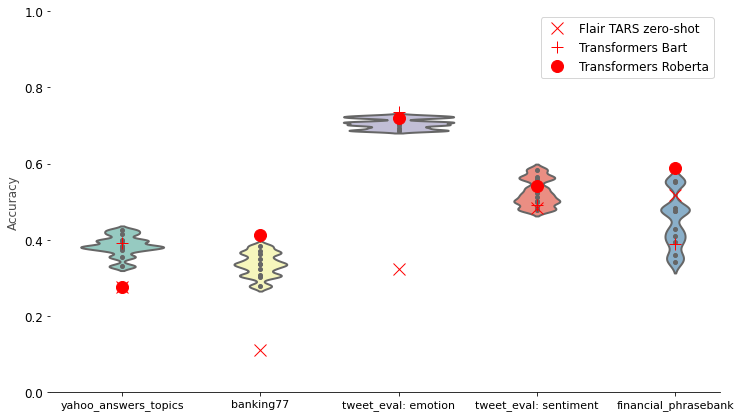

In [32]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import csv

df = pd.DataFrame(results_fewshot)
#sns.set(style="whitegrid")

f, ax = plt.subplots(figsize=(12, 7))

# Show each distribution with both violins and points
sns.violinplot(data=df, palette="Set3", inner="points",bw =.2, cut=2,linewidth=2, orient="v")

sns.despine(left=True)

#f.suptitle("TARS Few-Shot Learning", fontsize=18, fontweight='bold')
ax.set_ylabel("Accuracy", size = 12, alpha=0.7)
ax.set_ylim([0, 1])
#ax.set_ylabel("Model",size = 14, alpha=0.7)
for tick in ax.yaxis.get_major_ticks():
    tick.label.set_fontsize(12) 
for tick in ax.xaxis.get_major_ticks():
    tick.label.set_fontsize(11) 

    
for i, result in enumerate(results):
    ax.plot(i, results[data[i]['name']]['Flair TARS'], 'rx', markersize=12)
    ax.plot(i, results[data[i]['name']]['Transformers Bart'], 'r+', markersize=12)
    ax.plot(i, results[data[i]['name']]['Transformers Roberta'], 'ro', markersize=12)
    
ax.legend(['Flair TARS zero-shot', 'Transformers Bart', 'Transformers Roberta'], fontsize=12)

## Conclusions

Without a doubt, zero-shot learning is an extraordinary application of transfer learning. Zero-shot classifiers predict the class of a text without having seen a single labeled example, and in some cases do so with a higher accuracy than supervised models that have been trained on hundreds of labeled training items. Their success is far from guaranteed &mdash; it depends on the particular task and a careful selection of class names &mdash; but in the right circumstances, these models can get you a long way towards accurate text classification.

At the same time, the open-source zero-shot classifiers we tested out are no magic solutions, as it’s unlikely they are going to give you optimal performance on a specialized NLP task. For such applications, manually labeling a large number of examples, for example with a tool like <a href='https://www.tagalog.ai/'>Tagalog</a> still gives you the best chance of success. Even in those cases, however, zero-shot classification can prove useful, for example as a way to speed up manual labeling by suggesting potentially relevant labels to the annotators. It’s clear zero-shot and few-shot classification is here to stay, and can be a useful tool in any NLPer’s toolkit.